In [1]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input,Dense,GlobalAvgPool2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint,ReduceLROnPlateau
from captcha.image import ImageCaptcha  
import matplotlib.pyplot as plt
import numpy as np
import random
import string
from plot_model import plot_model

In [2]:
# 字符包含所有数字和所有大小写英文字母，一共62个
characters = string.digits + string.ascii_letters
# 类别数，包含一个空白符类别
num_classes = len(characters)+1
# 批次大小
batch_size = 64
# 训练集批次数
# 训练集大小相当于是64*1000=64000
train_steps = 1000
# 测试集批次数
# 测试集大小相当于是64*100=6400
test_steps = 100
# 周期数
epochs=100
# 图片宽度
width=160
# 图片高度
height=60
# 最长验证码
max_len = 6

In [3]:
# 用于自定义数据生成器
from tensorflow.keras.utils import Sequence

# 这里的Sequence定义其实不算典型，因为一般的数据集数量是有限的，
# 把所有数据训练一次属于训练一个周期，一个周期可以分为n个批次，
# Sequence一般是定义一个训练周期内每个批次的数据如何产生。
# 我们这里的验证码数据集使用captcha模块生产出来的，一边生产一边训练，可以认为数据集是无限的。
class CaptchaSequence(Sequence):
    # __getitem__和__len__是必须定义的两个方法
    def __init__(self, characters, batch_size, steps, width=160, height=60):
        # 字符集
        self.characters = characters
        # 批次大小
        self.batch_size = batch_size
        # 生成器生成多少个批次的数据
        self.steps = steps
        # 验证码长度随机，3-6位
        self.n_len = np.random.randint(3,7)
        # 验证码图片宽度
        self.width = width
        # 验证码图片高度
        self.height = height
        # 字符集长度
        self.num_classes = num_classes
        # 用于产生验证码图片
        self.image = ImageCaptcha(width=self.width, height=self.height)
        # 用于保存最近一个批次验证码字符
        self.captcha_list = []
    
    # 获得index位置的批次数据
    def __getitem__(self, index):
        # 初始化数据用于保存验证码图片
        x = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        # 初始化数据用于保存标签
        # 6个验证码识别任务，batch批次大小，num_classes分类数量
        y = np.zeros((max_len, self.batch_size, self.num_classes), dtype=np.float32)
        # 数据清0
        self.captcha_list = []
        # 初始化数据用于保存判断验证码长度的标签，一共4种情况
        len_captcha = np.zeros((self.batch_size, 4), dtype=np.int)
        # 生产一个批次数据
        for i in range(self.batch_size):
            # 随机产生验证码
            self.n_len = np.random.randint(3,7)
            # 设置标签，独热编码one-hot格式，一共4种情况
            len_captcha[i, self.n_len-3] = 1
            # 转字符串
            captcha_text = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            # 保存验证码
            self.captcha_list.append(captcha_text)
            # 生产验证码图片数据并进行归一化处理
            x[i] = np.array(self.image.generate_image(captcha_text)) / 255.0
            # j(0-3),i(0-61),ch(单个字符)
            # self.characters.find(ch)得到c在characters中的位置，可以理解为c的编号
            for j, ch in enumerate(captcha_text):
                # 设置标签，独热编码one-hot格式
                y[j, i, self.characters.find(ch)] = 1
            # 如果验证码长度不是6，则需要设置空白字符的标签为1
            # 空白字符在-1位置
            for k in range(len(captcha_text),max_len):
                # 空白字符
                y[k, i, -1] = 1
        # 返回一个批次的数据和标签
        return x, [y[0],y[1],y[2],y[3],y[4],y[5],len_captcha]
    
    # 返回批次数量
    def __len__(self):
        return self.steps 

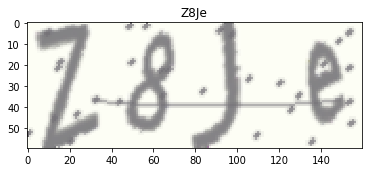

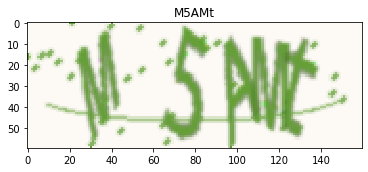

In [4]:
# 测试生成器
# 一共一个批次，批次大小也是1
data = CaptchaSequence(characters, batch_size=1, steps=1)
for i in range(2):
    # 产生一个批次的数据
    x, y = data[0]
    # 显示图片
    plt.imshow(x[0])
    # 验证码字符和对应编号
    plt.title(data.captcha_list[0])
    plt.show()

In [5]:
# 载入预训练的resnet50模型
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(height,width,3))

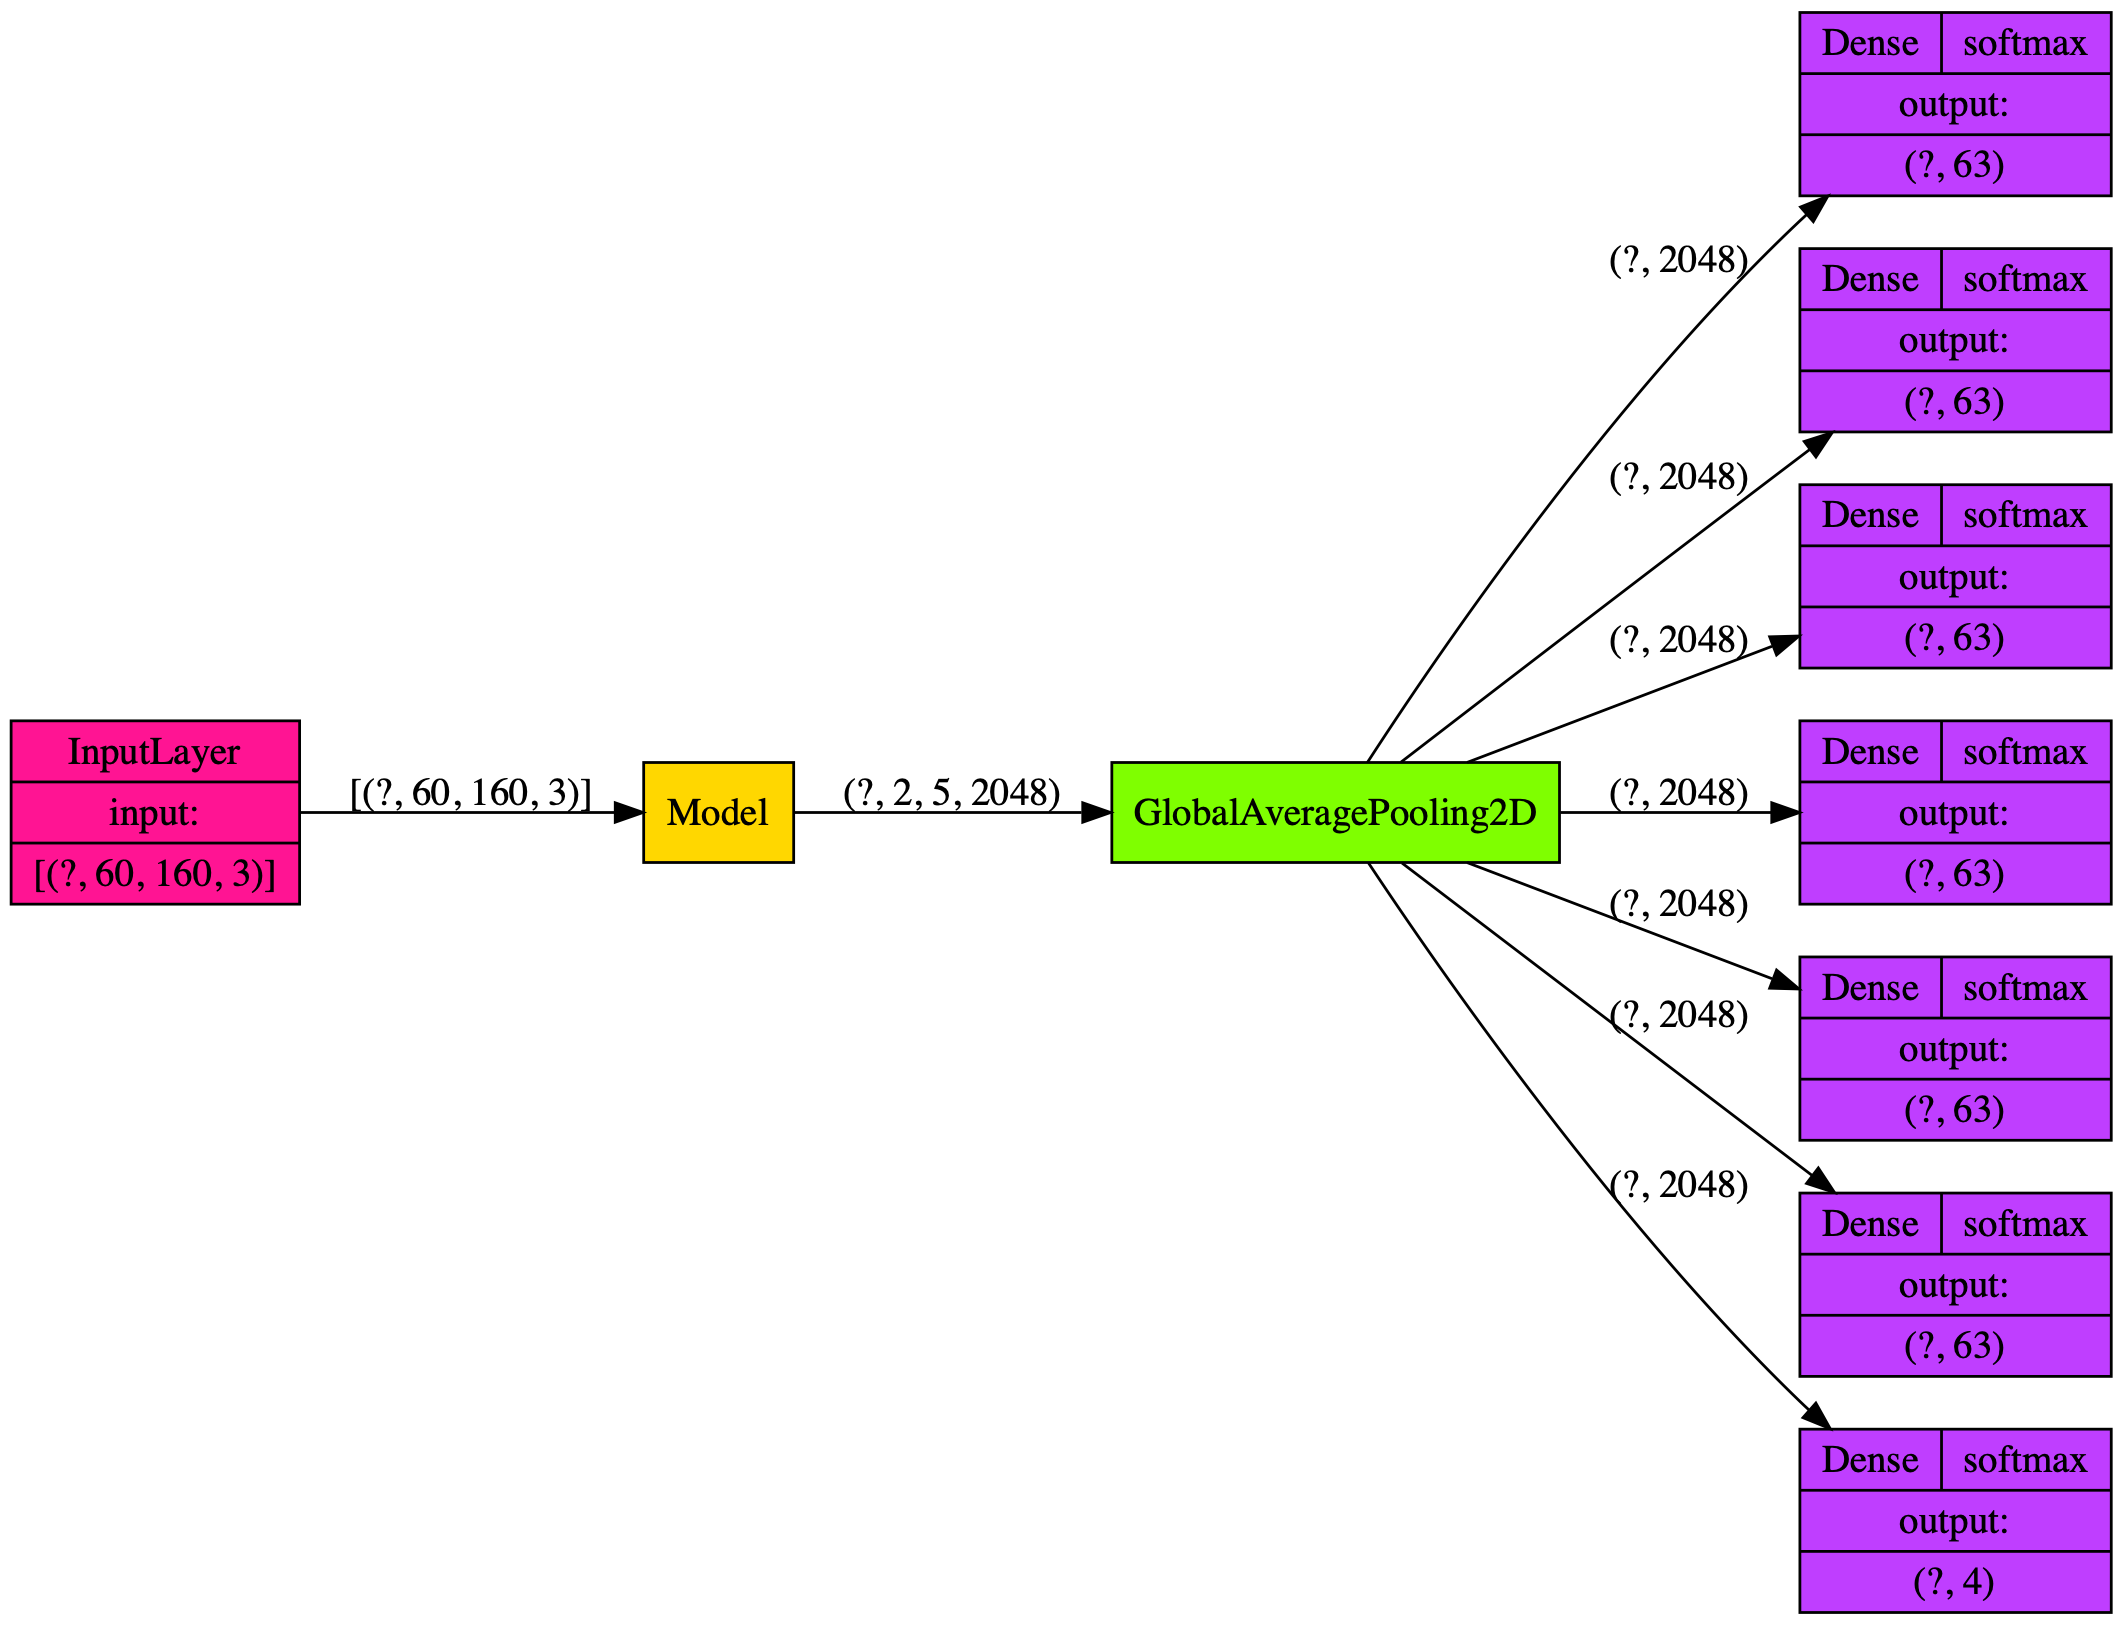

In [7]:
# 设置输入图片
inputs = Input((height,width,3))
# 使用resnet50进行特征提取
x = resnet50(inputs)
# 平均池化
x = GlobalAvgPool2D()(x)
# 每个任务负责识别1个字符
x0 = Dense(num_classes, activation='softmax', name='out0')(x)
x1 = Dense(num_classes, activation='softmax', name='out1')(x)
x2 = Dense(num_classes, activation='softmax', name='out2')(x)
x3 = Dense(num_classes, activation='softmax', name='out3')(x)
x4 = Dense(num_classes, activation='softmax', name='out4')(x)
x5 = Dense(num_classes, activation='softmax', name='out5')(x)
# 预测验证码长度3-6，4种情况所以定义4个分类
num_x = Dense(4, activation='softmax', name='out_num')(x)
# 定义模型
model = Model(inputs, [x0,x1,x2,x3,x4,x5,num_x])
# 画图
plot_model(model,style=0,dpi=200,rankdir='LR')

In [7]:
# loss_weights可以用来设置不同任务的权重，验证码识别的6个任务权重都一样
# 相对而言out_num更重要一些，因为如果验证码的长度判断错误，那么识别结果一定是错的
# 所以可以给out_num更大一点的权重
model.compile(loss={'out0':'categorical_crossentropy',
                    'out1':'categorical_crossentropy',
                    'out2':'categorical_crossentropy',
                    'out3':'categorical_crossentropy',
                    'out4':'categorical_crossentropy',
                    'out5':'categorical_crossentropy',
                    'out_num':'categorical_crossentropy'},
              loss_weights={'out0':1,
                            'out1':1,
                            'out2':1,
                            'out3':1,
                            'out4':1,
                            'out5':1,
                            'out_num':2},
              optimizer=SGD(lr=1e-2,momentum=0.9),
              metrics=['acc'])

# 监控指标统一使用val_loss
# 可以使用EarlyStopping来让模型停止，连续6个周期val_loss没有下降就结束训练
# CSVLogger保存训练数据
# ModelCheckpoint保存所有训练周期中val_loss最低的模型
# ReduceLROnPlateau学习率调整策略，连续3个周期val_loss没有下降当前学习率乘以0.1
callbacks = [EarlyStopping(monitor='val_loss', patience=6, verbose=1),
             CSVLogger('Captcha2.csv'), 
             ModelCheckpoint('Best_Captcha2.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

In [8]:
# 训练模型
model.fit(x=CaptchaSequence(characters, batch_size=batch_size, steps=train_steps),
            epochs=epochs,
            validation_data=CaptchaSequence(characters, batch_size=batch_size, steps=test_steps),
            callbacks=callbacks)

Train for 1000 steps, validate for 100 steps
Epoch 1/100
1000/1000 [==============================] - 184s 184ms/step - loss: 14.0520 - out0_loss: 2.2189 - out1_loss: 2.6810 - out2_loss: 2.9503 - out3_loss: 2.5608 - out4_loss: 1.8766 - out5_loss: 1.0524 - out_num_loss: 0.3560 - out0_acc: 0.4063 - out1_acc: 0.3020 - out2_acc: 0.2447 - out3_acc: 0.3636 - out4_acc: 0.5493 - out5_acc: 0.7673 - out_num_acc: 0.8614 - val_loss: 13.9098 - val_out0_loss: 2.5258 - val_out1_loss: 1.9578 - val_out2_loss: 2.3671 - val_out3_loss: 2.5046 - val_out4_loss: 1.6575 - val_out5_loss: 0.9196 - val_out_num_loss: 0.9887 - val_out0_acc: 0.4391 - val_out1_acc: 0.5095 - val_out2_acc: 0.4242 - val_out3_acc: 0.4322 - val_out4_acc: 0.6039 - val_out5_acc: 0.7880 - val_out_num_acc: 0.8316
Epoch 2/100
1000/1000 [==============================] - 179s 179ms/step - loss: 3.1590 - out0_loss: 0.3191 - out1_loss: 0.4697 - out2_loss: 0.5954 - out3_loss: 0.6664 - out4_loss: 0.5831 - out5_loss: 0.2816 - out_num_loss: 0.1219 -

Epoch 12/100
1000/1000 [==============================] - 179s 179ms/step - loss: 0.3435 - out0_loss: 0.0582 - out1_loss: 0.0708 - out2_loss: 0.0734 - out3_loss: 0.0639 - out4_loss: 0.0470 - out5_loss: 0.0235 - out_num_loss: 0.0033 - out0_acc: 0.9772 - out1_acc: 0.9733 - out2_acc: 0.9730 - out3_acc: 0.9770 - out4_acc: 0.9833 - out5_acc: 0.9919 - out_num_acc: 0.9992 - val_loss: 0.3198 - val_out0_loss: 0.0600 - val_out1_loss: 0.0666 - val_out2_loss: 0.0667 - val_out3_loss: 0.0639 - val_out4_loss: 0.0396 - val_out5_loss: 0.0196 - val_out_num_loss: 0.0017 - val_out0_acc: 0.9766 - val_out1_acc: 0.9711 - val_out2_acc: 0.9752 - val_out3_acc: 0.9761 - val_out4_acc: 0.9842 - val_out5_acc: 0.9917 - val_out_num_acc: 0.9995
Epoch 13/100
1000/1000 [==============================] - 179s 179ms/step - loss: 0.3212 - out0_loss: 0.0536 - out1_loss: 0.0681 - out2_loss: 0.0709 - out3_loss: 0.0602 - out4_loss: 0.0435 - out5_loss: 0.0213 - out_num_loss: 0.0018 - out0_acc: 0.9791 - out1_acc: 0.9749 - out2_a

 999/1000 [============================>.] - ETA: 0s - loss: 0.2494 - out0_loss: 0.0457 - out1_loss: 0.0523 - out2_loss: 0.0517 - out3_loss: 0.0464 - out4_loss: 0.0334 - out5_loss: 0.0174 - out_num_loss: 0.0013 - out0_acc: 0.9812 - out1_acc: 0.9796 - out2_acc: 0.9799 - out3_acc: 0.9822 - out4_acc: 0.9875 - out5_acc: 0.9931 - out_num_acc: 0.9997
Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
1000/1000 [==============================] - 178s 178ms/step - loss: 0.2494 - out0_loss: 0.0458 - out1_loss: 0.0523 - out2_loss: 0.0517 - out3_loss: 0.0464 - out4_loss: 0.0334 - out5_loss: 0.0174 - out_num_loss: 0.0013 - out0_acc: 0.9812 - out1_acc: 0.9796 - out2_acc: 0.9799 - out3_acc: 0.9822 - out4_acc: 0.9875 - out5_acc: 0.9931 - out_num_acc: 0.9997 - val_loss: 0.2273 - val_out0_loss: 0.0401 - val_out1_loss: 0.0499 - val_out2_loss: 0.0519 - val_out3_loss: 0.0401 - val_out4_loss: 0.0288 - val_out5_loss: 0.0159 - val_out_num_loss: 3.2215e-04 - val_out0_acc: 0.9836 - 